**Instruction for POS Tagging Using RNNs with Arabic Dataset**

**Dataset:**
The dataset provided is named "Assignment 2 - Arabic POS.conllu". It contains labeled data for Arabic text with Part-of-Speech (POS) tags in CoNLL-U format.

**Objective:**
Your objective is to perform Part-of-Speech (POS) tagging on Arabic text using Recurrent Neural Networks (RNNs). Specifically, you will use the Universal POS (UPOS) tags for tagging. UPOS is a standardized set of POS tags that aims to cover all languages.

**Evaluation metric:**
Accuracy

**Instructions:**
1. **Data Preprocessing:**
   - Load the provided dataset "Assignment 2 - Arabic POS.conllu". You can use pyconll library
   - Preprocess the data as necessary, including tokenization

2. **Model Building:**
   - Design an RNN-based model architecture suitable for POS tagging. You may consider using recurrent layers such as (LSTM) or (GRU).
   - Define the input and output layers of the model. The input layer should accept sequences of tokens, and the output layer should produce the predicted UPOS tags for each token.

3. **Training:**

4. **Evaluation:**

**Additional Notes:**
- Make sure to document your code thoroughly and provide clear explanations for each step.
- Feel free to explore different RNN architectures, hyperparameters, and optimization techniques to improve the model's accuracy.

### Import used libraries

In [55]:
!pip install pyconll

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [56]:
import re
import pyconll
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Bidirectional, Dropout ,SimpleRNN ,GRU
from tensorflow.keras.callbacks import ModelCheckpoint

### Load Dataset

In [57]:
corpus = pyconll.load_from_file("/kaggle/input/arabic-news-dataset/Assignment 2 - Arabic POS.conllu")

### Data Clean and Splitting

In [58]:
for i,sentence in enumerate(corpus[0:5]):
  seq =[]
  for token in sentence:
    seq.append(token.form)
  print(seq)
  break


['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']


In [59]:
def clean_data(token):
    if len(token) == 1 and re.match(r'[\u0600-\u06FF]', token):
        return ''
    return token

def clean_upos(pos):
    cleaned_pos = re.sub(r'[X]', '', pos)
    return cleaned_pos

clean_sentences = []
clean_upos_tags = []

for sentence in corpus:
    clean_tokens = []
    clean_tags = []
    for token in sentence:
        if token.form and token.upos:
            token_after_clean = clean_data(token.form)
            pos_after_clean = clean_upos(token.upos)
            if token_after_clean and pos_after_clean :
                clean_tokens.append(token_after_clean)
                clean_tags.append(pos_after_clean)
    if clean_tokens:
        clean_sentences.append(clean_tokens)
        clean_upos_tags.append(clean_tags)

In [60]:
for i ,j in zip(clean_sentences[0], clean_upos_tags[0]):
  print(f"Token: {i}, UPOS: {j}")

Token: ترفض, UPOS: VERB
Token: حصول, UPOS: NOUN
Token: شركة, UPOS: NOUN
Token: اميركية, UPOS: ADJ
Token: على, UPOS: ADP
Token: رخصة, UPOS: NOUN
Token: تصنيع, UPOS: NOUN
Token: دبابة, UPOS: NOUN
Token: ", UPOS: PUNCT
Token: ", UPOS: PUNCT
Token: الالمانية, UPOS: ADJ


In [61]:
X_train, X_test, y_train, y_test = train_test_split(clean_sentences,clean_upos_tags, test_size=0.2, random_state=42)

### Preprocessing

In [62]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)

Y_train_data = tag_tokenizer.texts_to_sequences(y_train)
Y_test_data = tag_tokenizer.texts_to_sequences(y_test)
tag_size = len(tag_tokenizer.word_index)

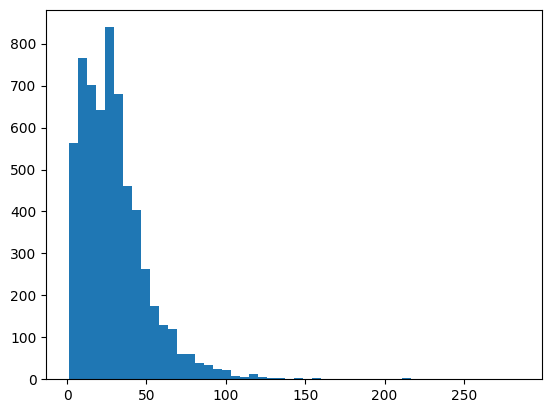

In [63]:
plt.hist([len(s) for s in clean_sentences], bins=50)
plt.show()

In [66]:
max_len = 75

X_train = pad_sequences(X_train_data, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test_data, maxlen=max_len, padding='post')

y_train = pad_sequences(Y_train_data, maxlen=max_len, padding='post')
y_test = pad_sequences(Y_test_data, maxlen=max_len, padding='post')

### Modelling

# RNN Model

In [67]:
Rnn_model = Sequential()
Rnn_model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=max_len))
Rnn_model.add(SimpleRNN(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
Rnn_model.add(TimeDistributed(Dense(tag_size+1, activation='softmax')))

In [68]:
Rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Rnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [69]:
X_train.shape

(4828, 75)

In [70]:
history = Rnn_model.fit(X_train, y_train, batch_size=32, epochs=5 ,validation_split=0.2,
                    validation_steps=30)

Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.3622 - loss: 2.1806 - val_accuracy: 0.6707 - val_loss: 0.9432
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6806 - loss: 1.0400 - val_accuracy: 0.8400 - val_loss: 0.5332
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7497 - loss: 0.8468 - val_accuracy: 0.7748 - val_loss: 0.7353
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7741 - loss: 0.7529 - val_accuracy: 0.8400 - val_loss: 0.4759
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7841 - loss: 0.7135 - val_accuracy: 0.7919 - val_loss: 0.6453


#### RNN Evaluation

In [71]:
loss, accuracy = Rnn_model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7768 - loss: 0.8234
Accuracy: 77.75%


# GRU MODEL

In [72]:
GRU_model = Sequential()
GRU_model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=max_len))
GRU_model.add(GRU(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
GRU_model.add(TimeDistributed(Dense(tag_size+1, activation='softmax')))

In [73]:
GRU_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
GRU_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
history = GRU_model.fit(X_train, y_train, batch_size=32, epochs=5 ,validation_split=0.2,
                    validation_steps=151)

Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.2131 - loss: 8.9359 - val_accuracy: 0.7183 - val_loss: 2.3453
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.5315 - loss: 4.1638 - val_accuracy: 0.7339 - val_loss: 2.0720
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6245 - loss: 2.1604 - val_accuracy: 0.7659 - val_loss: 1.6940
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6823 - loss: 1.3005 - val_accuracy: 0.7748 - val_loss: 1.4406
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.6846 - loss: 1.5216 - val_accuracy: 0.7748 - val_loss: 1.3103


#### GRU Evaluation

In [75]:
loss, accuracy = GRU_model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7718 - loss: 1.2963
Accuracy: 77.28%


# LSTM Model

In [76]:
LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=max_len))
LSTM_model.add(LSTM(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
LSTM_model.add(TimeDistributed(Dense(tag_size+1, activation='softmax')))

In [77]:
LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:
history = LSTM_model.fit(X_train, y_train, batch_size=32, epochs=5 ,validation_split=0.2,
                    validation_steps=30)

Epoch 1/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.6979 - loss: 1.3287 - val_accuracy: 0.7850 - val_loss: 0.6706
Epoch 2/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8305 - loss: 0.5802 - val_accuracy: 0.9400 - val_loss: 0.2200
Epoch 3/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9213 - loss: 0.2911 - val_accuracy: 0.9536 - val_loss: 0.1728
Epoch 4/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9659 - loss: 0.1441 - val_accuracy: 0.9733 - val_loss: 0.0800
Epoch 5/5
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9822 - loss: 0.0858 - val_accuracy: 0.9778 - val_loss: 0.0831


#### LSTM Evaluation

In [79]:
loss, accuracy = LSTM_model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8421 - loss: 1.1970
Accuracy: 84.05%


### Enhancement

#### Done!